In [1]:
#| default_exp hyperparam

In [2]:
#| export
import random, math, torch, numpy as np, matplotlib.pyplot as plt
from tinyai.model import *
from tinyai.learner import *
from tinyai.hooks import *
from tinyai.init import *
from tinyai.speedup import *
import fastcore.all as fc
from functools import partial
import time

In [3]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
import tiktoken
import os

enc = tiktoken.get_encoding("gpt2")

def get_tokens(input_file):
    with open(input_file) as f:
        text = f.read()
    tokens = enc.encode(text)
    return tokens

cwd = os.getcwd()
input_file = f"{cwd}/fast-nanogpt/input.txt"
tokens = get_tokens(input_file)[:150000]
train, valid = tokens[:int(len(tokens)*0.8)], tokens[int(len(tokens)*0.8):]

In [5]:
tds = DataSet(torch.tensor(train), T=512)
# vds = DataSet(torch.tensor(valid))
dls = DataLoaders.from_dd([tds, None], batch_size=4)
# dls = DataLoaders.from_dd([tds, vds], batch_size=4)
x, y = next(iter(dls.train))
x.shape, y.shape, len(tds), len(dls.train)

(torch.Size([4, 512]), torch.Size([4, 512]), 234, 59)

## Adam optimizer, and gradient clipping
GPT-2 weights are available, but the paper does not say much about training. GPT-3 paper provides more details about training, but the weights are not available. The two models have similar architecture, so we can use GP-3 training details to train GPT-2.
> To train all versions of GPT-3, we use Adam with β1 = 0.9, β2 = 0.95, and = 10−8, we clip the global norm of the gradient at 1.0

In [6]:
#| export
admw = partial(optim.AdamW, betas=(0.9, 0.95), eps=1e-8)

In [7]:
TrainCB??

Init signature: TrainCB()
Docstring:      <no docstring>
Source:        
class TrainCB(Callback):

    def predict(self, learn):
        # import pdb; pdb.set_trace()
        learn.preds, learn.loss = learn.model(*learn.batch)
        # print("epoch", learn.epoch, "step", learn.iter, "loss", learn.loss.item())

    def backward(self, learn):
        learn.loss.backward()

    def step(self, learn):
        learn.opt.step()

    def zero_grad(self, learn):
        learn.opt.zero_grad()
File:           ~/playground/notebooks/fast-nanogpt/tinyai/learner.py
Type:           type
Subclasses:     MixedPrecisionTrainCB

In [8]:
#| export
class NormGradTrainCB(TrainCB):

    def backward(self, learn):
        learn.loss.backward()
        learn.grad_nom = nn.utils.clip_grad_norm_(learn.model.parameters(), 1.0)


## Learning rate schedule
> and we use cosine decay for learning rate down to 10% of its value, over 260 billion tokens (after 260 billion tokens, training continues at 10% of the original learning rate). There is a linear LR warmup over the first 375 million tokens.

In [9]:
def plot_func(func, x_range=(-2, 2), n_points=100):
    x = np.linspace(x_range[0], x_range[1], n_points)
    y = [func(i) for i in x]
    plt.plot(x, y)
    # plt.show()

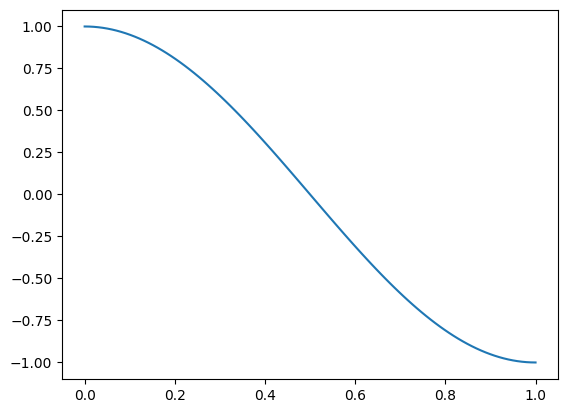

In [10]:
plot_func(lambda x: math.cos(math.pi * x), (0,  1))

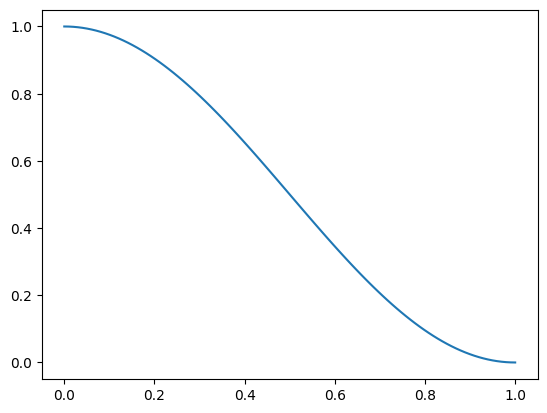

In [11]:
plot_func(lambda x: 0.5 * (1.0 + math.cos(math.pi * x)), (0,  1))

In [12]:
#| export
def get_lr(step, max_lr, min_lr, warmup_steps, max_steps):
    # linear warmup stage
    if step < warmup_steps:
        # there is no point of 0 lr even in the first step
        return max_lr * (step + 1) / warmup_steps

    # steps exceeding annealing stage are clamped to min_lr
    if step > max_steps:
        return min_lr

    # cosine decay
    decay_ratio = (step - warmup_steps) / (max_steps - warmup_steps)
    decay_ratio = min(max(0.0, decay_ratio), 1.0)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coefficent starts from 1 and goes to 0

    return min_lr + (max_lr - min_lr) * coeff

In [ ]:
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 10
max_steps = 50
plot_func(
    lambda x: partial(
        get_lr,
        max_lr=max_lr,
        min_lr=min_lr,
        warmup_steps=1000,
        max_steps=5000,
    )(x),
    (0, 5000),
    5000,
)

In [14]:
#| export
class CosineLR(torch.optim.lr_scheduler.LRScheduler):
    def __init__( self, optimizer, warmup_steps, max_steps, ratio=0.1, last_epoch=-1, verbose=False):
        self.max_lr = optimizer.param_groups[0]["lr"]
        self.min_lr = self.max_lr * ratio
        self.warmup_steps = warmup_steps
        self.max_steps = max_steps
        super().__init__(optimizer=optimizer, last_epoch=last_epoch, verbose=verbose)

    def get_lr(self):
        return [
            get_lr(
                self._step_count,
                self.max_lr,
                self.min_lr,
                self.warmup_steps,
                self.max_steps,
            )
            for base_lr in self.base_lrs
        ]

In [15]:
#| export
class ScheduleCB(Callback):

    def __init__(self, schedule_fn):
        self.schedule_fn = schedule_fn
    
    def before_fit(self, learn):
        self.sched = self.schedule_fn(learn.opt)

    def after_batch(self, learn):
        self.sched.step()

In [16]:
#| export
class RecordCB(Callback):

    def __init__(self, **d):
        # d is a dictionary of items to record and functions to calculate them
        self.d = d

    def before_fit(self, learn):
        self.recs = {k: [] for k in self.d.keys()}

    def after_batch(self, learn):
        if not learn.training:
            return
        for k, v in self.d.items():
            self.recs[k].append(v(self, learn))
    
    def plot(self):
        for k, v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [17]:
#| export
def _lr(cb, learn):
    return learn.opt.param_groups[0]['lr']

In [18]:
#| export
def _grad_norm(cb, learn):
    return learn.grad_nom.detach().cpu()

In [19]:
cbs = [NormGradTrainCB(), InitWeightsCB(), DeviceCB(), MetricsCB(), ProgressCB()]
def fit(model, epochs=1, xtra_cbs=None, lr=3e-4):
    lrn = Learner(model, dls=dls, opt_func=admw, cbs=cbs + fc.L(xtra_cbs), lr=lr)
    lrn.fit(epochs, valid=False)
    return lrn

In [20]:
record = RecordCB(lr=_lr, grad_norm=_grad_norm)
schd = ScheduleCB(partial(CosineLR, warmup_steps=10, max_steps=50))

In [21]:
set_seed(1337)
model = get_model()

TODO: weight decay

In [22]:
fit(model, xtra_cbs=[record, schd], lr=6e-4)

loss,epoch,train
6.907,0,train


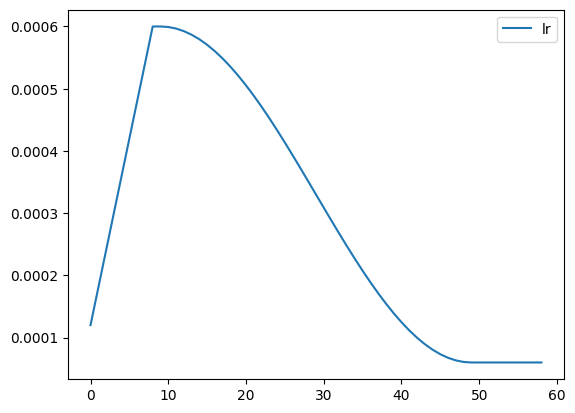

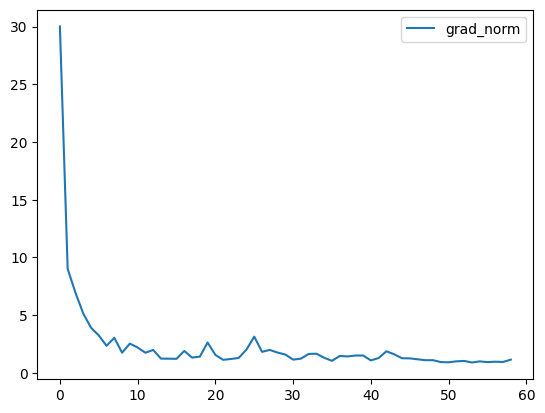

In [23]:
record.plot()

TODO: gradient accumulate